In [1]:
#Stock market price predictor
#1.stock rises over a period of time
#2.stock market price estimate month wise


In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [64]:
#Data retriving and index manipulation
def input(label):
    ibm=yf.Ticker(label)
    ibm=ibm.history(period="max")
    ibm.to_csv(label)
    return ibm
ibm=input("IBM")
ibm=ibm.loc["1990-01-01":].copy()
ibm.index=pd.to_datetime(ibm.index)
ibm.index=ibm.index.date
ibm=ibm.drop(columns=["Dividends" ,"Stock Splits"],errors="ignore")

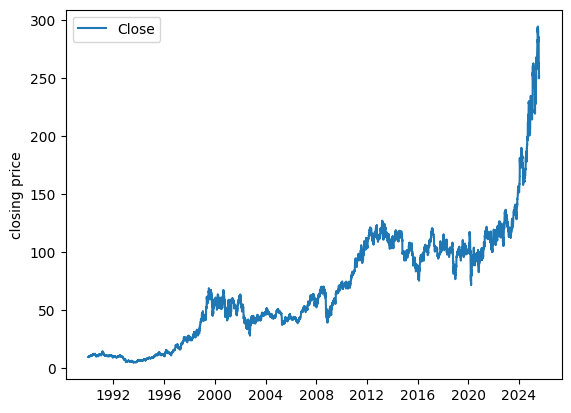

In [65]:
def datavisualisation(dataset):
    dataset.plot.line(y="Close" , ylabel="closing price",legend=["Close"],use_index=True)
datavisualisation(ibm)

In [66]:
#Data splitting 
train=ibm.iloc[:-100]
test=ibm.iloc[-100:]

feature=["High","Open","Low","Volume","Close"]
ibm["Tommorrow"]=ibm["Close"].shift(-1)
ibm["Target"]=(ibm["Tommorrow"]>ibm["Close"]).astype(int)
#model preparation for 1
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=100, min_samples_split=100 ,random_state=1,n_jobs=-1)

def prediction(model , test ,train, feature):
    model.fit(train[feature],train["Target"])
    preds=model.predict_proba(test[feature])[:,1]
    preds[preds>=0.4]=1
    preds[preds<0.4]=0
    preds=pd.Series(preds,index=test.index,name="Predictions")
    preds=pd.concat((preds,test["Target"]),axis=1)
    return preds

In [67]:
#backtracking
def back_tracking(model , data ,feature ,start=2500 ,step=250):
    all_prediction=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predict= prediction(model,test,train,feature)
        all_prediction.append(predict)
    return pd.concat(all_prediction)

In [68]:
#Precision_score
predicts=back_tracking(model,ibm,feature)
from sklearn.metrics import precision_score
precision_score(predicts["Predictions"],predicts["Target"])

0.8546109942925804

In [69]:
predicts["Predictions"].value_counts()

Predictions
1.0    5512
0.0     951
Name: count, dtype: int64

<Axes: ylabel='Closing prices'>

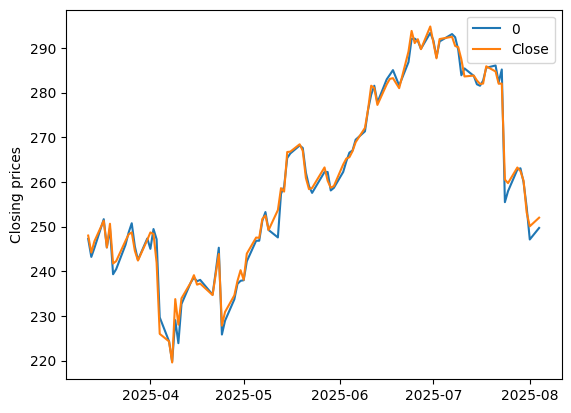

In [70]:
#model 2
from sklearn.linear_model import LinearRegression
feature=["High","Open","Low","Volume"]
m2=LinearRegression()
m2.fit(train[feature],train["Close"])

predsl=m2.predict(test[feature])
predsl=pd.Series(predsl,index=test.index)
combined=pd.concat((predsl,test["Close"]),axis=1)
combined.plot.line(ylabel="Closing prices" ,use_index=True ,legend=["Predicted","Actual"])

In [71]:
predsl

2025-03-12    247.239872
2025-03-13    243.199161
2025-03-14    245.196380
2025-03-17    251.652815
2025-03-18    245.321463
                 ...    
2025-07-29    263.041674
2025-07-30    259.933180
2025-07-31    254.333666
2025-08-01    247.100531
2025-08-04    249.683539
Length: 100, dtype: float64

In [72]:
#precision check

from sklearn.metrics import mean_squared_error ,mean_absolute_error ,r2_score

mse=mean_squared_error(test["Close"],predsl)
mae=mean_absolute_error(test["Close"],predsl)
r2_score=r2_score(test["Close"],predsl)

print("MSE :",mse)
print("MAE :",mae)
print("r2_score :",r2_score)

MSE : 2.9880265348066395
MAE : 1.2334605339464377
r2_score : 0.992425622791508


In [73]:
#Predicting stock price for next month
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dense


In [74]:
#stationary or not
from statsmodels.tsa.stattools import adfuller
close_series = ibm["Close"]

def check_stationary(series):
    result =adfuller(series)
    print(result[1])

check_stationary(close_series)

0.9982350960252424


In [81]:
#future dates
from datetime import timedelta
last_row=ibm.iloc[-1].copy()
future_Dates=pd.date_range(last_row.name+timedelta(days=1),periods=60,freq="B")

future_data=pd.DataFrame(index=future_Dates,columns=["Close"])
future_data.index=future_data.index.date


In [76]:
from sklearn.model_selection import train_test_split
closing_price=ibm["Close"].values
def create_dataset(data,lookback):
    feature=[]
    target=[]
    for i in range(len(data)-lookback):
        feature.append(data[i:i+lookback])
        target.append(data[i+lookback])
    return np.array(feature) ,np.array(target)
feat,target=create_dataset(closing_price,lookback=60)

In [82]:
from sklearn.linear_model import LinearRegression
m2=LinearRegression();
m2.fit(feat,target)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [83]:
def pred_60_days(modele,dataset,days=60):
    prediction=[];
    input_seq=dataset[-60:].copy()
    for i in range(days):

        #input reshaped as predict uses 2D array
        input_reshaped=input_seq.reshape(1,60)
        preds=m2.predict(input_reshaped)[0]
        prediction.append(preds)
        input_seq = np.append(input_seq[1:], preds)
    prediction=np.array(prediction)
    return prediction

future_prices=pred_60_days(m2,ibm["Close"].values)
future_data["Close"]=future_prices
future_data

combine=pd.concat((ibm,future_data))

<Axes: ylabel='Closing price'>

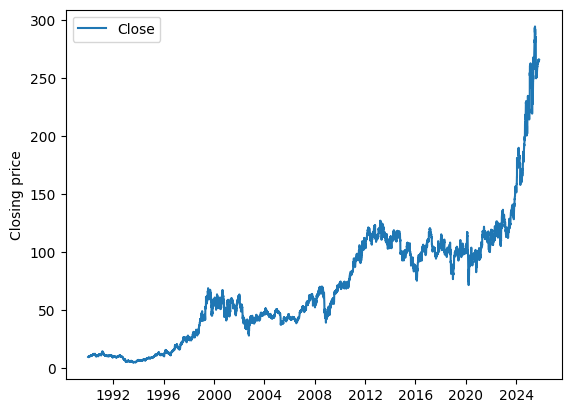

In [79]:
combine.plot.line(y="Close",ylabel="Closing price",use_index=True)

<Axes: ylabel='Closing price'>

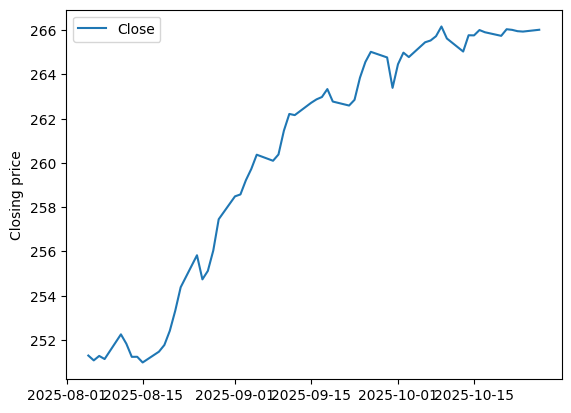

In [80]:
future_data.plot.line(y="Close",ylabel="Closing price",use_index=True)